In [1]:
import numpy as np
from stonesoup.models.transition.linear import (
    ConstantVelocity,
    CombinedLinearGaussianTransitionModel
    )
from stonesoup.predictor.kalman import ExtendedKalmanPredictor
from stonesoup.updater.kalman import ExtendedKalmanUpdater
from stonesoup.models.measurement.nonlinear import (
    CartesianToElevationBearingRange
    )
from stonesoup.types.array import CovarianceMatrix


transition_model = CombinedLinearGaussianTransitionModel(
    [ConstantVelocity(1.0),
     ConstantVelocity(1.0),
     ConstantVelocity(1.0)])

# Model coords = elev, bearing, range. Angles in radians
meas_covar = np.diag([np.radians(np.sqrt(10.0))**2,
                      np.radians(0.6)**2,
                      3.14**2])

meas_covar_trk = CovarianceMatrix(1.0*meas_covar)
meas_model = CartesianToElevationBearingRange(
            ndim_state=6,
            mapping=np.array([0, 2, 4]),
            noise_covar=meas_covar_trk)
predictor = ExtendedKalmanPredictor(transition_model)
updater = ExtendedKalmanUpdater(measurement_model=meas_model)

from stonesoup.reader.generic import CSVGroundTruthReader

ground_truth_reader = CSVGroundTruthReader(
    path='UAV_Rot.csv',
    state_vector_fields=['longitude', 'Vx m/s', 'latitude', 'Vy m/s', 'altitude (m)'],
    time_field='time',
    path_id_field='groupNb',
)

from stonesoup.feeder.geo import LLAtoENUConverter
sensor_location = [-30.948, 50.297311666, 0]  # Radar position [long, lat, alt]
ground_truth_reader = LLAtoENUConverter(ground_truth_reader, sensor_location, [0, 2, 4])

from stonesoup.platform.base import FixedPlatform
from stonesoup.sensor.radar.radar import RadarElevationBearingRange
from stonesoup.simulator.platform import PlatformDetectionSimulator
from stonesoup.types.state import State

sensor = RadarElevationBearingRange(
    position_mapping=[0, 2, 4],
    noise_covar=meas_covar,
    ndim_state=6,
)
platform = FixedPlatform(
    State([0, 0, 0, 0, 0, 0]),  # Sensor at reference point, zero velocity
    position_mapping=[0, 2, 4],
    sensors=[sensor]
)

# Create the detector and initialize it.
detector = PlatformDetectionSimulator(ground_truth_reader, [platform])

from stonesoup.types.state import GaussianState, State
from stonesoup.types.update import GaussianStateUpdate
from stonesoup.initiator.simple import SimpleMeasurementInitiator
from stonesoup.types.track import Track
from stonesoup.types.hypothesis import SingleHypothesis


class Initiator(SimpleMeasurementInitiator):
    def initiate(self, detections, timestamp, **kwargs):
        MAX_DEV = 400.
        tracks = set()
        measurement_model = self.measurement_model
        for detection in detections:
            state_vector = measurement_model.inverse_function(
                            detection)
            model_covar = measurement_model.covar()

            el_az_range = np.sqrt(np.diag(model_covar)) #elev, az, range

            std_pos = detection.state_vector[2, 0]*el_az_range[1]
            stdx = np.abs(std_pos*np.sin(el_az_range[1]))
            stdy = np.abs(std_pos*np.cos(el_az_range[1]))
            stdz = np.abs(detection.state_vector[2, 0]*el_az_range[0])
            if stdx > MAX_DEV:
                print('Warning - X Deviation exceeds limit!!')
            if stdy > MAX_DEV:
                print('Warning - Y Deviation exceeds limit!!')
            if stdz > MAX_DEV:
                print('Warning - Z Deviation exceeds limit!!')
            C0 = np.diag(np.array([stdx, 30.0, stdy, 30.0, stdz, 30.0])**2)

            tracks.add(Track([GaussianStateUpdate(
                state_vector,
                C0,
                SingleHypothesis(None, detection),
                timestamp=detection.timestamp)
            ]))
        return tracks


prior_state = GaussianState(
        np.array([[0], [0], [0], [0], [0], [0]]),
        np.diag([0, 30.0, 0, 30.0, 0, 30.0])**2)
initiator = Initiator(prior_state, meas_model)
#initiator = SimpleMeasurementInitiator(prior_state, meas_model)

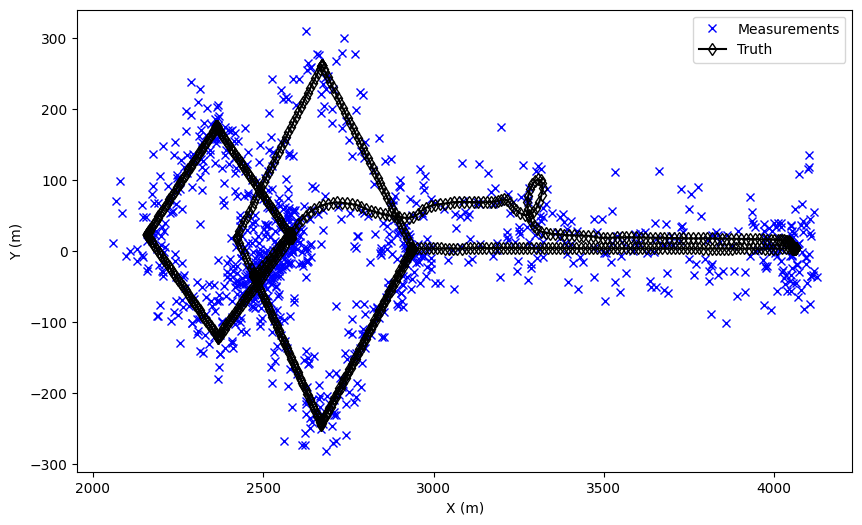

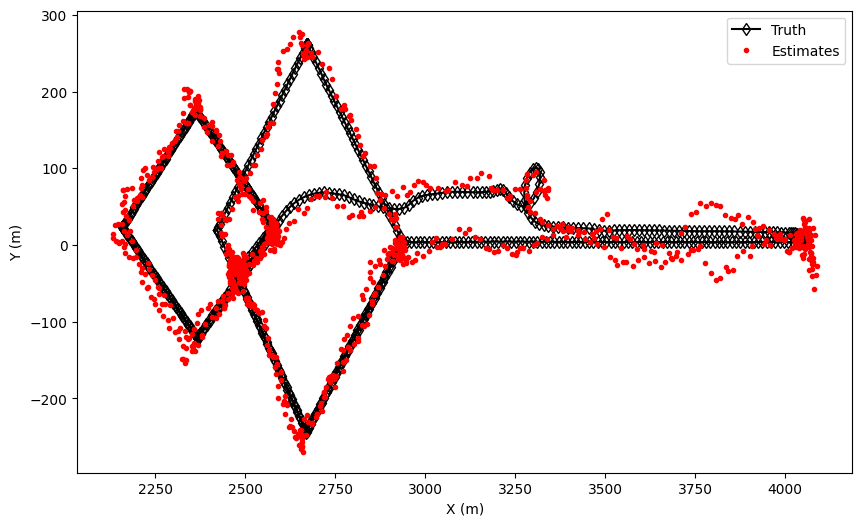

In [3]:
class MyDeleter:
    def delete_tracks(self, tracks):
        return set()

deleter = MyDeleter()

from stonesoup.measures import Euclidean
from stonesoup.dataassociator.neighbour import NearestNeighbour
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.tracker.simple import SingleTargetTracker
meas = Euclidean()
hypothesiser = DistanceHypothesiser(predictor, updater, meas)
associator = NearestNeighbour(hypothesiser)


tracker = SingleTargetTracker(initiator,
                              deleter,
                              detector,
                              associator,
                              updater)

from matplotlib import pyplot as plt
est_X=[]
est_Y=[]
meas_X=[]
meas_Y=[]
true_X = []
true_Y = []
for time, tracks in tracker:
    for ground_truth in ground_truth_reader.groundtruth_paths:
        true_X.append(ground_truth.state_vector[0])
        true_Y.append(ground_truth.state_vector[2])

    # Because this is a single target tracker, I know there is only 1 track.
    for track in tracks:

        #Get the corresponding measurement
        detection = track.states[-1].hypothesis.measurement
        # Convert measurement into xy
        xyz = meas_model.inverse_function(detection)
        meas_X.append(xyz[0])
        meas_Y.append(xyz[2])

        vec = track.states[-1].state_vector
        est_X.append(vec[0])
        est_Y.append(vec[2])

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
plt.plot(meas_X, meas_Y, 'xb', label='Measurements')
ax1.plot(true_X, true_Y, 'd-k', label='Truth', markerfacecolor='None')
ax1.legend()
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')

fig = plt.figure(figsize=(10, 6))
ax2 = fig.add_subplot(1, 1, 1)
ax2.plot(true_X, true_Y, 'd-k', label='Truth', markerfacecolor='None')
ax2.plot(est_X, est_Y, 'r.', label='Estimates')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.legend()